# **Data Visualization**

## Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import seaborn as sns

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk import bigrams
import string
from wordcloud import WordCloud
from collections import Counter

# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')

## Load The original Dataset


In [2]:
df_origin = pd.read_csv('../data/ireland-news-headlines.csv')
df = df_origin.copy()

## Arrange The Dataset

### Division of the data frame into columns of headline_category, headline_text, year, month and day

In [3]:
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y%m%d')
df['year'] = df['publish_date'].dt.year
df['month'] = df['publish_date'].dt.month
df['day'] = df['publish_date'].dt.day
df.drop('publish_date', axis=1, inplace=True)
print(df.shape)
df.head()

(1611495, 5)


,headline_category,headline_text,year,month,day
0,news,UUP sees possibility of voting Major out,1996,1,2
1,news,Pubs targeted as curbs on smoking are extended,1996,1,2
2,news,Papers reveal secret links with O'Neill cabinet,1996,1,2
3,news,Domestic chaos as Italy takes EU presidency,1996,1,2
4,news,Learning about the star to which we owe life,1996,1,2


### Erase duplicated rows and nan cells

In [4]:
def drop_nan(df_nan):
    df_nan = df_nan.dropna() 
    df_nan = df_nan.reset_index()
    df_nan = df_nan.iloc[:,1:]
    return df_nan

In [5]:
print(f'Number of duplicated rows: {df.iloc[:,:-3].duplicated().sum()}')
print(f'Number of Nans cells: {df.iloc[:,:-3].isna().sum()}')
df.drop_duplicates(subset=['headline_category', 'headline_text'],inplace=True)
df = drop_nan(df)
print(df.shape)

Number of duplicated rows: 86916
Number of Nans cells: headline_category    0
headline_text        7
dtype: int64
(1524575, 5)


In [6]:
data_to_clean = df.copy()

## Visualization

Split the headline category to 4 levels

First we will only look at the headline in the first level

In [7]:
df[['headline_category', 'headline_category_2', 'headline_category_3', 'headline_category_4']] = df['headline_category'].str.split('.', expand=True)
Num_pri_classes = len(df['headline_category'].unique())
print(f'Number of primary classes: {Num_pri_classes}')
Names_pri_classes = df['headline_category'].unique()
print(f'The classes are: {Names_pri_classes}')
Num_all_classes = len(df_origin['headline_category'].unique())
print(f'Number of all the classes: {Num_all_classes}')

Number of primary classes: 6
The classes are: ['news' 'culture' 'opinion' 'business' 'sport' 'lifestyle']
Number of all the classes: 103


### Distribution of publications of article types by years, months and days

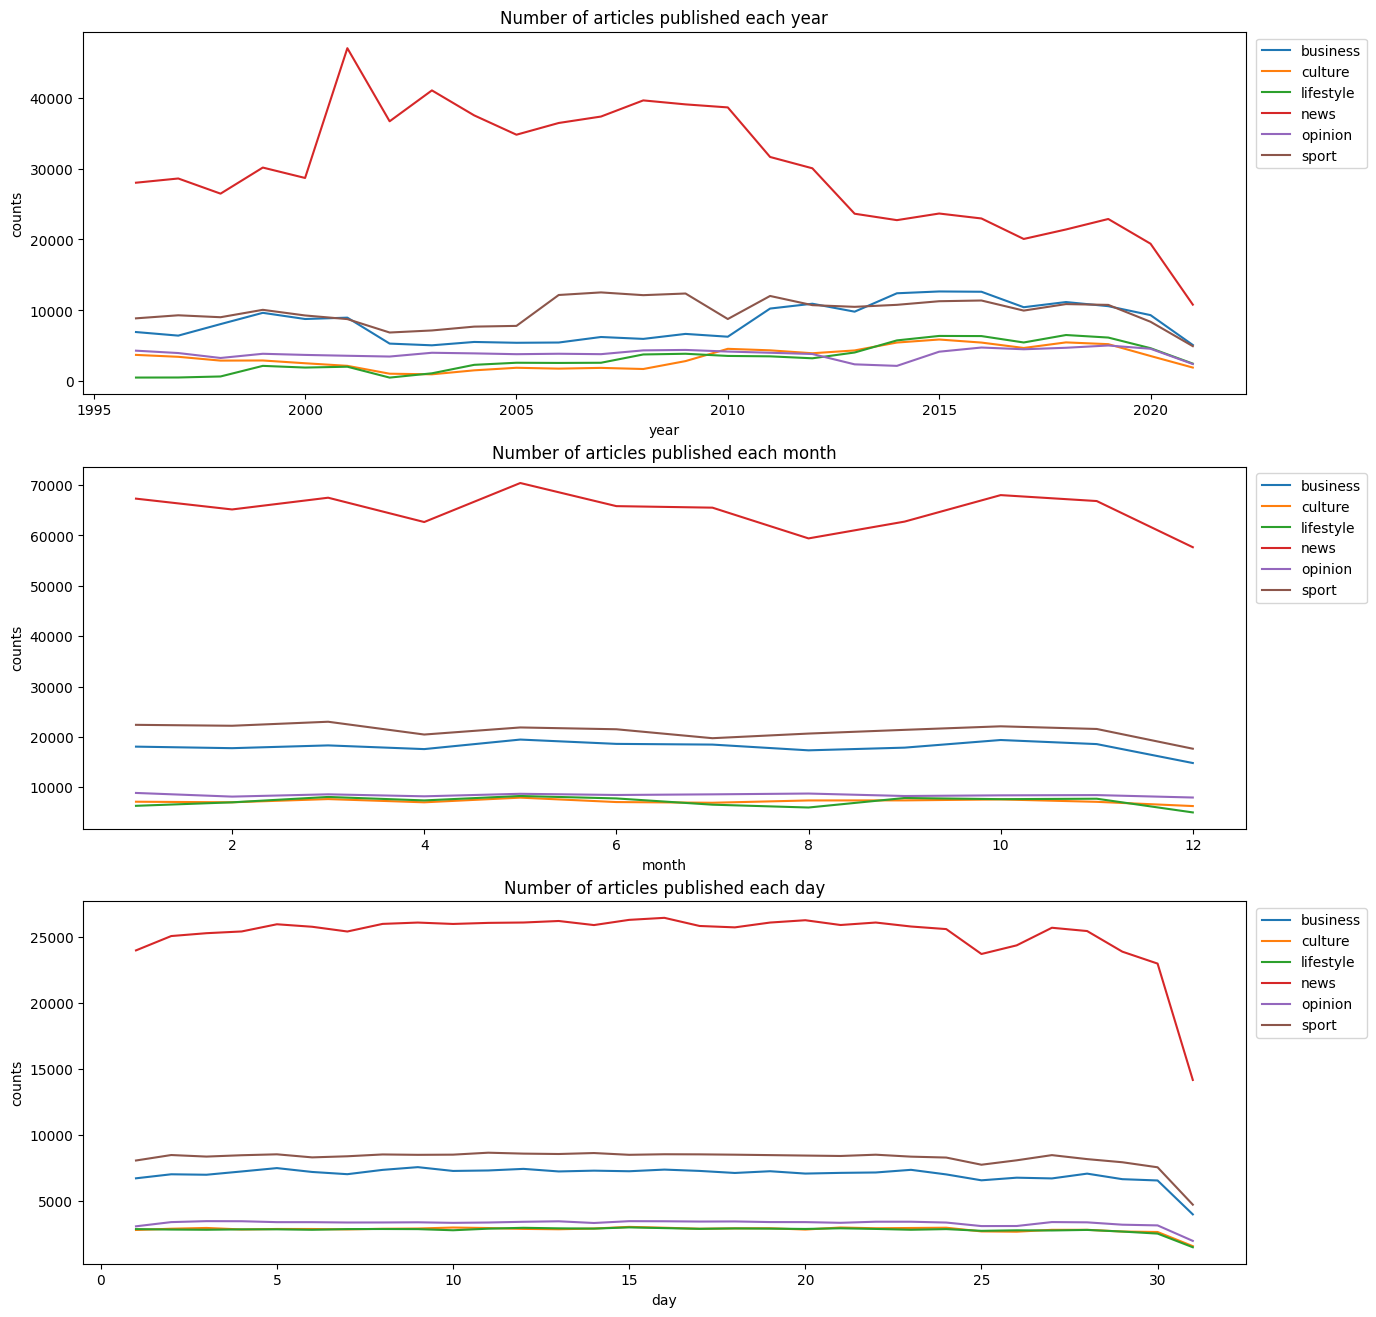

In [8]:
fig, axs=plt.subplots(3,1,figsize=(15,16))
df.groupby(['year','headline_category'])['headline_category'].agg('count').unstack('headline_category').plot(ax=axs[0])
axs[0].legend(loc=0, ncol=1,bbox_to_anchor=(1.11,1))
axs[0].set_title("Number of articles published each year")
axs[0].set_ylabel('counts')
axs[0].set_xlabel('year')
df.groupby(['month','headline_category'])['headline_category'].agg('count').unstack('headline_category').plot(ax=axs[1])
axs[1].legend(loc=0, ncol=1,bbox_to_anchor=(1.11,1))
axs[1].set_title("Number of articles published each month")
axs[1].set_ylabel('counts')
axs[1].set_xlabel('month')
df.groupby(['day','headline_category'])['headline_category'].agg('count').unstack('headline_category').plot(ax=axs[2])
axs[2].legend(loc=0, ncol=1,bbox_to_anchor=(1.11,1))
axs[2].set_title("Number of articles published each day")
axs[2].set_ylabel('counts')
axs[2].set_xlabel('day')
plt.show()


### Distribution of article by category

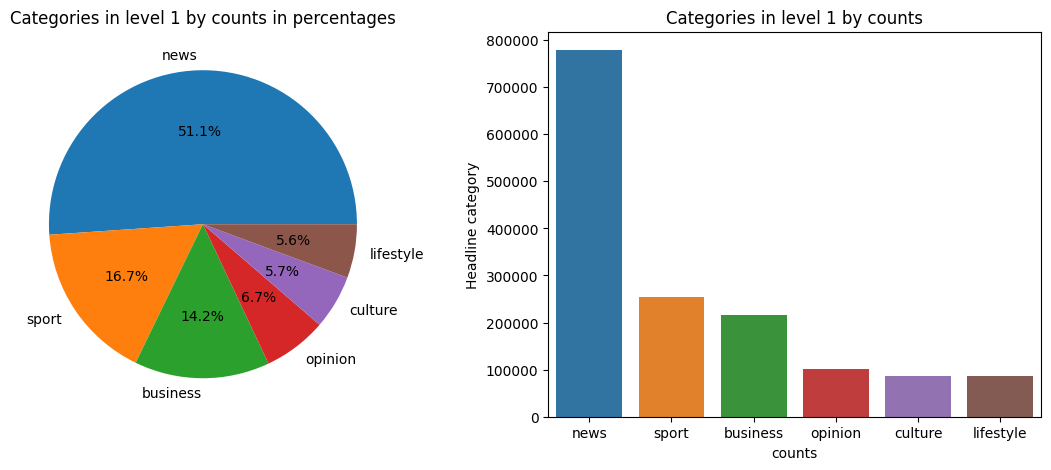

In [9]:
fig,axs=plt.subplots(1,2, figsize=(14,5))
category_counts = df['headline_category'].value_counts()
axs[0].pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
axs[0].set_title('Categories in level 1 by counts in percentages')
sns.barplot(y=df.headline_category.value_counts(),x=df.headline_category.value_counts().index, capsize=True, ax=axs[1])
axs[1].set_title("Categories in level 1 by counts")
axs[1].set_xlabel('counts')
axs[1].set_ylabel('Headline category')
plt.show()

### Entity Names
Search for people's names and city names that repeat themselves many times by category

In [10]:
# Initialize dictionaries to store the results
people_dict = {}
cities_dict = {}
num_of_sen = 0
# Iterate over each unique headline category
for category in df['headline_category'].unique():
    category_df = df[df['headline_category'] == category]
    # print(category)
    people = []
    cities = []
    
    # Iterate over the headlines in the current category
    for headline in category_df['headline_text']:
        words = word_tokenize(headline)
        tagged_words = pos_tag(words)
        named_entities = ne_chunk(tagged_words)
        
        # Extract names of people and cities
        for entity in named_entities:
            if hasattr(entity, 'label') and entity.label() == 'PERSON':
                people.append(' '.join([name for name, tag in entity.leaves()]))
            elif hasattr(entity, 'label') and entity.label() == 'GPE':
                cities.append(' '.join([name for name, tag in entity.leaves()]))
        # num_of_sen +=1
        # if num_of_sen%100000 == 0: print(f'Number of sentences = {num_of_sen}')
    people_count = Counter(people)
    cities_count = Counter(cities)

    people_dict[category] = people_count
    cities_dict[category] = cities_count

In [11]:
def print_top_n(top_n_dict, category_name, subject, n):
    top_n = sorted(top_n_dict[category_name].items(), key=lambda x: x[1], reverse=True)[:n]    
    print(f'The top {n} {subject} in category {category_name}, is: {top_n}')
    return

#### People names

In [15]:
print_top_n(people_dict, 'news', 'People names', 10)
print_top_n(people_dict, 'sport', 'People names', 10)
print_top_n(people_dict, 'lifestyle', 'People names', 10)
print_top_n(people_dict, 'opinion', 'People names', 10)
print_top_n(people_dict, 'culture', 'People names', 10)
print_top_n(people_dict, 'business', 'People names', 10)


The top 10 People names in category news, is: [('Man', 5154), ('Woman', 3500), ('Dublin', 3258), ('Bill', 2700), ('Bush', 2252), ('Garda', 2155), ('Blair', 2125), ('Trump', 1998), ('Clinton', 1947), ('Kenny', 1884)]
The top 10 People names in category sport, is: [('Munster', 1844), ('Liverpool', 1623), ('Leinster', 1342), ('Kerry', 1335), ('Dublin', 1273), ('Derry', 1142), ('Ulster', 959), ('Ferguson', 879), ('Rory', 834), ('Cork', 767)]
The top 10 People names in category lifestyle, is: [('Dublin', 414), ('Róisín', 253), ('Ross', 221), ('Christmas', 221), ('Michael', 203), ('Moncrieff', 168), ('Story', 148), ('Kerry', 141), ('Ticket', 133), ('Paul', 127)]
The top 10 People names in category opinion, is: [('Irishman', 1047), ('Frank McNally', 378), ('Una', 335), ('Brexit', 332), ('Dublin', 323), ('Trump', 320), ('David', 226), ('Breda', 222), ('Kathy Sheridan', 210), ('Stephen', 205)]
The top 10 People names in category culture, is: [('Dublin', 450), ('John', 310), ('Album Review', 201

At first it seems that the classification of the names did not always work as expected but you can see a number of interesting names according to category.
It can be seen that among the names that are repeated many times in the 'News' category are the presidents of the United States: Bill Clinton, George Bush, Donald Trump.
In addition, it can be seen that the names that are repeated many times in the 'Sport' category are the former coach of Manchester United Alex Ferguson, and the golfer Rory McIlroy.

#### City names

In [17]:
print_top_n(cities_dict, 'news', 'Cities', 8)
print_top_n(cities_dict, 'sport', 'Cities', 8)
print_top_n(cities_dict, 'culture', 'Cities', 8)
print_top_n(cities_dict, 'opinion', 'Cities', 8)
print_top_n(cities_dict, 'business', 'Cities', 8)
print_top_n(cities_dict, 'lifestyle', 'Cities', 8)

The top 8 Cities in category news, is: [('Irish', 16772), ('EU', 12224), ('Dublin', 10323), ('Ireland', 9747), ('New', 6219), ('Iraq', 5470), ('North', 5022), ('British', 4826)]
The top 8 Cities in category sport, is: [('Ireland', 9475), ('Irish', 6393), ('England', 4112), ('United', 3026), ('Dublin', 1863), ('Chelsea', 1841), ('France', 1679), ('Cork', 1506)]
The top 8 Cities in category culture, is: [('Irish', 2831), ('Ireland', 1392), ('Dublin', 592), ('New', 521), ('Review', 420), ('British', 212), ('Belfast', 207), ('Radio', 179)]
The top 8 Cities in category opinion, is: [('Irish', 4204), ('Ireland', 2224), ('EU', 1178), ('Brexit', 569), ('Dublin', 561), ('North', 531), ('Fintan', 514), ('Europe', 504)]
The top 8 Cities in category business, is: [('Irish', 10151), ('Ireland', 4942), ('EU', 3855), ('Dublin', 2743), ('European', 2492), ('New', 2114), ('China', 1640), ('Ryanair', 1481)]
The top 8 Cities in category lifestyle, is: [('Irish', 3081), ('Ireland', 1972), ('Dublin', 973),

You can see that we got names of cities mainly in Ireland, you can also see that we got names that call to football teams under sports like United, and Chelsea.

### Bigrams
Search Bigrams that repeat themselves many times by category

In [18]:
# Initialize a dictionary to store the results
bigrams_dict = {}
num_of_sen = 0
# Iterate over each unique headline category
for category in df['headline_category'].unique():
    category_df = df[df['headline_category'] == category]
    # print(category)
    category_bigrams = []
    # Iterate over the headlines in the current category
    for headline in category_df['headline_text']:
        tokens = word_tokenize(headline)
        headline_bigrams = list(bigrams(tokens))
        category_bigrams.extend(headline_bigrams)
        # num_of_sen +=1
        # if num_of_sen%100000 == 0: print(f'Number of sentences = {num_of_sen}')
    bigram_counts = Counter(category_bigrams)
    bigrams_dict[category] = bigram_counts

In [43]:
print_top_n(bigrams_dict, 'news', 'Bigrams', 12)
print_top_n(bigrams_dict, 'business', 'Bigrams', 12)
print_top_n(bigrams_dict, 'culture', 'Bigrams', 12)
print_top_n(bigrams_dict, 'sport', 'Bigrams', 12)
print_top_n(bigrams_dict, 'lifestyle', 'Bigrams', 12)
print_top_n(bigrams_dict, 'opinion', 'Bigrams', 12)

The top 10 Bigrams in category news, is: [((';', 'says'), 12822), ((';', '000'), 12413), (('to', 'be'), 11540), (('of', 'the'), 5903), (('killed', 'in'), 5846), (('calls', 'for'), 4991), (('in', 'the'), 4923), (('in', 'Dublin'), 4607), (('jailed', 'for'), 3445), (('on', 'the'), 3259)]
The top 10 Bigrams in category business, is: [((';', '000'), 3125), (('to', 'be'), 2039), ((';', 'says'), 1990), (('in', 'the'), 1724), (('of', 'the'), 1618), (('set', 'to'), 1611), (('Aer', 'Lingus'), 1473), (('to', 'create'), 1375), (('on', 'the'), 1316), (('Bank', 'of'), 1266)]
The top 10 Bigrams in category culture, is: [(('of', 'the'), 3659), (('review', ':'), 3397), (('in', 'the'), 1879), ((':', 'The'), 1767), ((':', 'A'), 1320), (('on', 'the'), 1232), (('.', '.'), 1158), (("'", 'I'), 1098), ((':', 'a'), 1061), (('to', 'the'), 1046)]
The top 10 Bigrams in category sport, is: [(('in', 'the'), 3376), (('of', 'the'), 3348), (('to', 'be'), 2679), (('on', 'the'), 2482), (('out', 'of'), 2362), (('World', 

It can be seen that we received many combinations of conjunctions in the English language. Apart from that, it can be seen that under the 'News' category we received negative combinations related to death and prison. And a number of other interesting combinations under different categories.

## Clean The Data

* converting all letters to lower case
* removing numbers
* removing punctuations
* removing stop words
* Inflections of a word

In [9]:
data_to_clean

,headline_category,headline_text,year,month,day
0,news,UUP sees possibility of voting Major out,1996,1,2
1,news,Pubs targeted as curbs on smoking are extended,1996,1,2
2,news,Papers reveal secret links with O'Neill cabinet,1996,1,2
3,news,Domestic chaos as Italy takes EU presidency,1996,1,2
4,news,Learning about the star to which we owe life,1996,1,2
...,...,...,...,...,...
1524570,news.politics.oireachtas,Reserve members of Defence Forces to be allowe...,2021,6,30
1524571,culture,Maureen Dowd: Joe Biden is 'crazy about the Ir...,2021,6,30
1524572,sport.others,Andy Murray rolls back the years to own Centre...,2021,6,30
1524573,news.health,Delta variant could do 'significant damage' in...,2021,6,30


In [10]:
words_to_clean = ['u', '-','–']
stemmer= PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def clean_data(df_to_clean):
    df_to_clean.insert(2, "clean_headline_text",  None)
    for i, text in enumerate(df_to_clean["headline_text"]):
        clean_text = text.lower() # converting all letters to lower case
        clean_text = re.sub(r'\d+', '', clean_text) # removing numbers
        clean_text = clean_text.translate(str.maketrans("","", string.punctuation)) # removing punctuations
        clean_text = clean_text.strip() # removing whitespaces
        wo_sw = ''
        for word in clean_text.split():
            if word not in stopwords: # removing stop words
                word = stemmer.stem(word)
                word = lemmatizer.lemmatize(word) # Inflections of a word
                if word not in words_to_clean: # removing words_to_clean
                    wo_sw += word + ' '
        clean_text = wo_sw 
        if len(clean_text) > 1:
            df_to_clean["clean_headline_text"][i] = clean_text
    return df_to_clean

In [ ]:
# Clean data
data_to_clean = clean_data(data_to_clean)
# Drop Nan
data_to_clean = drop_nan(data_to_clean)
print(f'Number of Nans cells: {data_to_clean.isna().sum()}')

## Split the dataset
We split the data set to 2 sets:
*  6 classes set - The first level of the headline category
*  25 classes set - All the classes with more then 10k samples

### 6 classes set

In [22]:
# 6 classes: 
df_6_category = data_to_clean.copy()
df_6_category[['headline_category', 'headline_category_2', 'headline_category_3', 'headline_category_4']] = df_6_category['headline_category'].str.split('.', expand=True)
df_6_category = df_6_category.iloc[:,:-3]

### 25 classes set

In [23]:
# 25 classes: 
df_25_category = data_to_clean.copy()
k = 0
for cat in df_25_category['headline_category'].unique():
    summ = sum(df_25_category['headline_category'] == cat)
    if summ > 10000:
        k +=1
        # print(f'headline_category: {cat} number of rows: {summ}')
print(f'Number of classes with more then 10,000 samples: {k}')


Number of classes with more then 10,000 samples: 25


#### Distribution of article by category (25 classes)

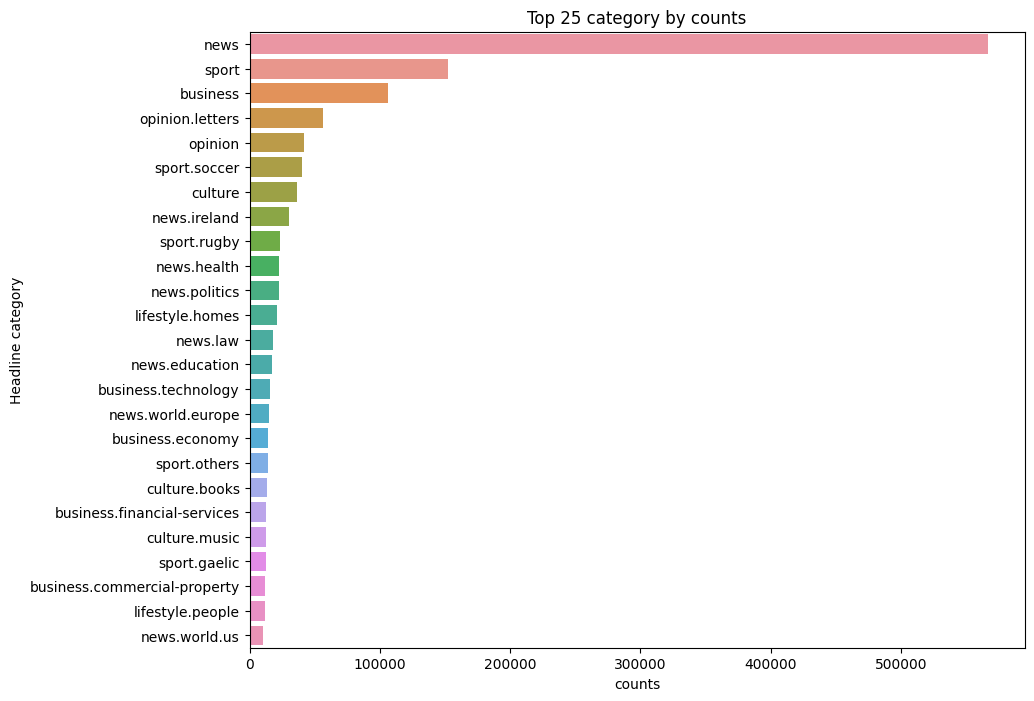

In [24]:
fig,ax=plt.subplots(figsize=(10,8))
df_25_category=df_25_category[df_25_category['headline_category'].isin(list(df_25_category.headline_category.value_counts()[:25].index[:25]))]
sns.barplot(y=df_25_category.headline_category.value_counts().index,x=df_25_category.headline_category.value_counts(),ax=ax)
ax.set_title("Top 25 category by counts")
ax.set_xlabel('counts')
ax.set_ylabel('Headline category')
plt.show()

#### Save the cleaned data

In [30]:
# save cleaned data
# df_25_category.to_csv('../data/ireland-news-headlines-cleaned-25.csv')  
# df_6_category.to_csv('../data/ireland-news-headlines-cleaned-6.csv')  

## Visualization of the cleaned data
For categories in the first level (6 classes)

### Load cleaned data

In [26]:
# load cleaned data
df_cleaned = pd.read_csv('../data/ireland-news-headlines-cleaned-6.csv')
df_cleaned = df_cleaned.iloc[:,1:]

### Display of repeated words by category in a word cloud

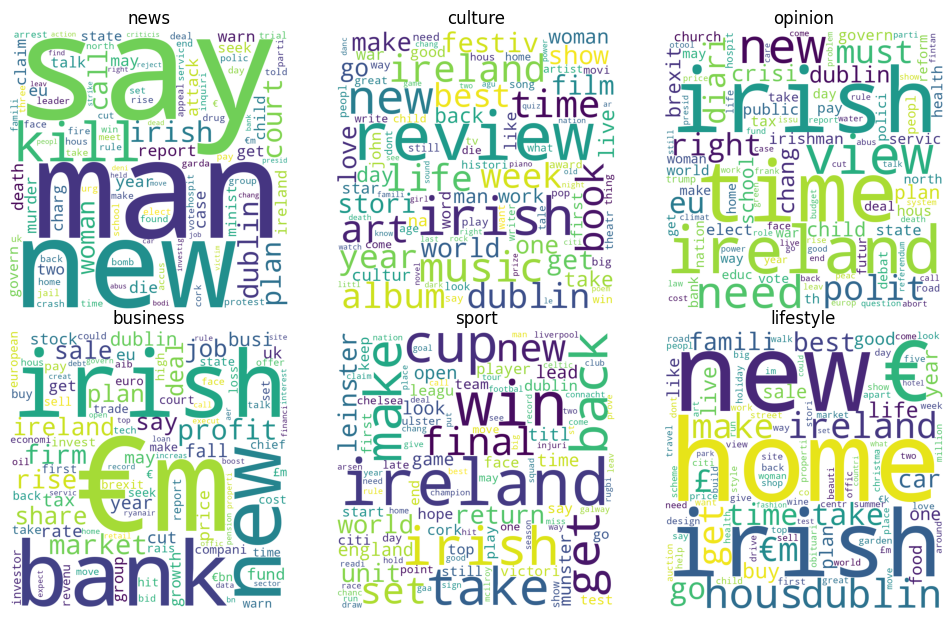

In [19]:
word_clouds = []
top_5 = []
for cat in df_cleaned['headline_category'].unique():
    
    df3 = df_cleaned[df_cleaned['headline_category'] == cat] 
    df3 = df3['clean_headline_text'].astype(str)
    text = ' '.join(df3.tolist())

    word_frequencies = {}
    for word in text.split():
        if word not in word_frequencies:
            word_frequencies[word] = 0
        word_frequencies[word] += 1

    wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(word_frequencies)
    word_clouds.append(wordcloud)
    top_5_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:5]
    top_5.append(top_5_words)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), facecolor=None)
axes[0, 0].imshow(word_clouds[0])
axes[0, 0].set_title('news')
axes[0, 0].axis('off')
axes[0, 1].imshow(word_clouds[1])
axes[0, 1].set_title('culture')
axes[0, 1].axis('off')
axes[0, 2].imshow(word_clouds[2])
axes[0, 2].set_title('opinion')
axes[0, 2].axis('off')
axes[1, 0].imshow(word_clouds[3])
axes[1, 0].set_title('business')
axes[1, 0].axis('off')
axes[1, 1].imshow(word_clouds[4])
axes[1, 1].set_title('sport')
axes[1, 1].axis('off')
axes[1, 2].imshow(word_clouds[5])
axes[1, 2].set_title('lifestyle')
axes[1, 2].axis('off')
plt.tight_layout(pad=0)
    
plt.show()

#### Top 5 words in each classes

In [20]:
i = 0
for cat in df_cleaned['headline_category'].unique():
    print(f'Top 5 words in {cat}:')
    print(top_5[i])
    i+=1

Top 5 words in news:
[('say', 34132), ('man', 29779), ('new', 23105), ('kill', 19599), ('irish', 17992)]
Top 5 words in culture:
[('review', 5898), ('irish', 3355), ('new', 2681), ('music', 1998), ('art', 1695)]
Top 5 words in opinion:
[('irish', 4584), ('time', 4099), ('ireland', 2722), ('view', 2289), ('new', 1813)]
Top 5 words in business:
[('€m', 11864), ('irish', 10824), ('bank', 10210), ('new', 9467), ('profit', 7730)]
Top 5 words in sport:
[('ireland', 10283), ('win', 9553), ('cup', 6959), ('irish', 6764), ('take', 6465)]
Top 5 words in lifestyle:
[('home', 3937), ('new', 3671), ('irish', 3338), ('€', 2771), ('hous', 2563)]


---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------